In [33]:
%matplotlib inline
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3
import os

# display numbers with thousand separator
pd.options.display.float_format = '{:,.0f}'.format

plt.style.use ('ggplot')

In [34]:
city_flows_dfs = []
metro_flows_dfs = []

#data_path ='/home/franknitty/irs_nyc_migration/data'
data_path = '/Users/anastasiaclark/irs_nyc_migration/data'
db = 'irsmig_county_database'
con = sqlite3.connect (os.path.join (data_path, db, "irs_migration_county.sqlite"))
metros = pd.read_csv (os.path.join (data_path, 'metros', 'metros_basic.csv'),
                      converters={'fips': str, 'co_code': str, 'cbsa_code': str})

years = ('2011_12', '2012_13', '2013_14', '2014_15')  # project years

# NYC counties
nyc = ('36005', '36047', '36061', '36081', '36085')

# NY Metro Counties
nyma=('34003','34013','34017','34019','34023','34025','34027','34029','34031',\
      '34035','34037','34039','36005','36027','36047','36059','36061','36071',\
      '36079','36081','36085','36087','36103','36119','42103')

# codes for foreign migration
foreign=('57005','57009','57001','57003','57007')

# codes for counties with suppressed flows
suppressed=('58000','59000')

In [35]:
def get_flows_by_city(year, city):
    """ function to read in data from the database
    and select only flows for selected city

    :rtype: dataframe"""

    # read in inflow & outflow data and store it in a pandas dataframe
    table1 = 'outflow_{}'.format (year)
    table2 = 'inflow_{}'.format (year)

    # SQL query to select 
    # flows between, but not within counties
    df_out = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table1, table1, table1), con)
    df_in = pd.read_sql_query ("SELECT * from {} where {}.origin!={}.destination".format (table2, table2, table2), con)

    # Make the index to be same for same records
    df_out['uid'] = df_out.origin + "_" + df_out.destination
    df_in['uid'] = df_in.origin + "_" + df_in.destination

    df_in.set_index ('uid', inplace=True)
    df_out.set_index ('uid', inplace=True)
    
    # select a subset of records between and not within city's counties
    city_in = df_in[(df_in['destination'].isin (city)) & (~df_in['origin'].isin (city))]
    city_out = df_out[(df_out['origin'].isin (city)) & (~df_out['destination'].isin (city))]
    
    
    to_city = city_in[['origin', 'co_orig_name', 'exemptions', 'st_orig_abbrv']].groupby (
        ['origin', 'co_orig_name', 'st_orig_abbrv']).sum().sort_values ('exemptions', ascending=False).reset_index ()
    from_city = city_out[['destination', 'co_dest_name', 'st_dest_abbrv', 'exemptions']].groupby (
        ['destination', 'co_dest_name', 'st_dest_abbrv']).sum().sort_values ('exemptions',
                                                                              ascending=False).reset_index ()
    to_city.rename (columns={'origin': 'co_fips', 'co_orig_name': 'co_name', 'exemptions': 'inflow' + year,
                             'st_orig_abbrv': 'state'}, inplace=True)
    from_city.rename (columns={'destination': 'co_fips', 'co_dest_name': 'co_name', 'st_dest_abbrv': 'state',
                               'exemptions': 'outflow' + year}, inplace=True)

    flows_city = to_city.merge (from_city, on=['co_fips', 'co_name', 'state'], how='outer')
    flows_city.fillna(0, inplace=True)

    # merge metro areas info to nyc flows to determine which counties from these flows are urban
    flows_city = flows_city.merge (metros[['cbsa_code', 'cbsa_name', 'fips']], left_on='co_fips', right_on='fips',
                                   how='left').drop ('fips', 1)
    
    # label counties that are nor part of the metro areas and are not supressed or foregin as non-metro counties
    flows_city.loc[(~flows_city['co_fips'].isin(suppressed)) & (~flows_city['co_fips'].isin(foreign)) & (flows_city['cbsa_code'].isnull()),['cbsa_name']]='non-metro'
    #flows_city.loc[flows_city['cbsa_name'].isnull(),'cbsa_name'] = 'n/a'
    # add calculated columns
    flows_city['net_flow' + year] = flows_city['inflow' + year] - flows_city['outflow' + year]
    #flows_city['in_ratio' + year] = flows_city['inflow' + year] / flows_city['outflow' + year]
    return flows_city

In [36]:
# this part is specific to NYC/NY metro , but can be repeated for any other city/metro

# run the functions to get inflow/outflow data for New York city and for NY metro area
# for each year and append the results to a list
for year in years:
    city_flows_dfs.append (get_flows_by_city (year, nyc))

for year in years:
    metro_flows_dfs.append (get_flows_by_city (year, nyma))

# merge all years dfs for NYC (Metro) from the list into a single df
city_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'cbsa_code', 'cbsa_name'], how='outer'), city_flows_dfs)
metro_flows=reduce(lambda x, y: pd.merge(x, y, on = ['co_fips', 'co_name', 'state', 'cbsa_code', 'cbsa_name'], how='outer'), metro_flows_dfs)

In [37]:
city_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,inflow2014_15,outflow2014_15,net_flow2014_15
0,36059,Nassau County,NY,"13,995","22,803",35620,"New York-Newark-Jersey City, NY-NJ-PA","-8,808","14,458","24,494","-10,036","13,877","25,204","-11,327","11,900","20,316","-8,416"
1,59000,Other flows - Different State,DS,"13,850","16,808",NaN,NaN,"-2,958","14,062","17,381","-3,319","21,728","25,405","-3,677","19,743","23,807","-4,064"
2,36119,Westchester County,NY,"11,588","16,967",35620,"New York-Newark-Jersey City, NY-NJ-PA","-5,379","10,806","18,414","-7,608","10,438","17,173","-6,735","9,048","13,986","-4,938"
3,36103,Suffolk County,NY,"8,838","9,785",35620,"New York-Newark-Jersey City, NY-NJ-PA",-947,"7,493","9,636","-2,143","7,056","9,271","-2,215","5,837","8,171","-2,334"
4,34017,Hudson County,NJ,"6,308","8,761",35620,"New York-Newark-Jersey City, NY-NJ-PA","-2,453","6,270","9,141","-2,871","5,729","8,818","-3,089","4,709","7,273","-2,564"


In [38]:
metro_flows.head()

,co_fips,co_name,state,inflow2011_12,outflow2011_12,cbsa_code,cbsa_name,net_flow2011_12,inflow2012_13,outflow2012_13,net_flow2012_13,inflow2013_14,outflow2013_14,net_flow2013_14,inflow2014_15,outflow2014_15,net_flow2014_15
0,59000,Other flows - Different State,DS,"52,457","64,047",NaN,NaN,"-11,590","53,426","65,070","-11,644","76,655","97,033","-20,378","64,452","83,652","-19,200"
1,09001,Fairfield County,CT,"7,122","11,486",14860,"Bridgeport-Stamford-Norwalk, CT","-4,364","7,644","12,518","-4,874","7,366","12,205","-4,839","5,901","9,683","-3,782"
2,12086,Miami-Dade County,FL,"6,898","7,790",33100,"Miami-Fort Lauderdale-West Palm Beach, FL",-892,"6,736","6,860",-124,"4,475","6,283","-1,808","3,371","5,216","-1,845"
3,06037,Los Angeles County,CA,"6,814","9,134",31080,"Los Angeles-Long Beach-Anaheim, CA","-2,320","6,891","11,001","-4,110","6,656","9,915","-3,259","5,246","8,233","-2,987"
4,12011,Broward County,FL,"5,905","7,732",33100,"Miami-Fort Lauderdale-West Palm Beach, FL","-1,827","5,887","7,711","-1,824","4,450","7,330","-2,880","3,450","6,002","-2,552"


# What was the number of in-migrants, out-migrants, and net change for domestic (internationl) migration for NYC / NYM (year by year and cumulative)?

In [39]:
# get subsets of domestic and foreign flows separately
domestic_city_flows=city_flows[~city_flows['co_fips'].isin (foreign)].copy()
foreign_city_flows=city_flows[city_flows['co_fips'].isin (foreign)].copy()

domestic_metro_flows=metro_flows[~metro_flows['co_fips'].isin (foreign)].copy()
foreign_metro_flows=metro_flows[metro_flows['co_fips'].isin (foreign)].copy()

In [40]:
def get_total_flows(df):
  in_mig=pd.DataFrame(df[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].sum(axis=0), columns=['in_migration']).reset_index().rename(columns={'index':'years'})
  in_mig['years']=in_mig.years.apply(lambda x :x[-7:])
  out_mig=pd.DataFrame(df[['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15']].sum(axis=0), columns=['out_migration']).reset_index().rename(columns={'index':'years'})
  out_mig['years']=out_mig.years.apply(lambda x :x[-7:])
  df_total=pd.merge(in_mig,out_mig, on='years')
  df_total['net_migration']=df_total['in_migration']-df_total['out_migration']
  df_total.set_index('years',inplace=True)  
  return df_total

In [41]:
# total domestic and foreign migrations for NYC and NYMA
total_city_foreign=get_total_flows(foreign_city_flows)
total_city_dom=get_total_flows(domestic_city_flows)

total_metro_dom=get_total_flows(domestic_metro_flows)
total_metro_foreign=get_total_flows(foreign_metro_flows)

In [42]:
# check one
# checked net migration for domestic and foreign; numbers are correct except domestic 2013_14 and 2014_15
# difference is very small - likely due to the handling of the 94 duplicate records we found
# So this is actually not a problem - checks out ok
total_city_dom

,in_migration,out_migration,net_migration
years,,,
2011_12,"180,459","245,886","-65,427"
2012_13,"173,813","257,056","-83,243"
2013_14,"161,752","247,407","-85,655"
2014_15,"140,397","202,264","-61,867"


In [43]:
# year by year plots
def plot_migration(df, title):
    ax=df[['in_migration','out_migration']].plot(kind='bar', rot=0, legend=False, color=['#A0CCCF','#FFB834'])
    df['net_migration'].plot(kind='bar', ax=ax, rot=0, color='#006944', width=0.2)
    ax.legend (bbox_to_anchor=(1.07, 1), loc='upper left')
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    ax.set_title(title)
    plt.show()

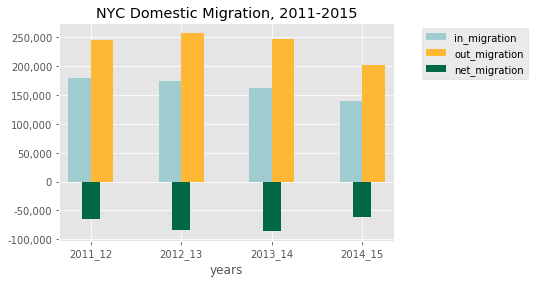

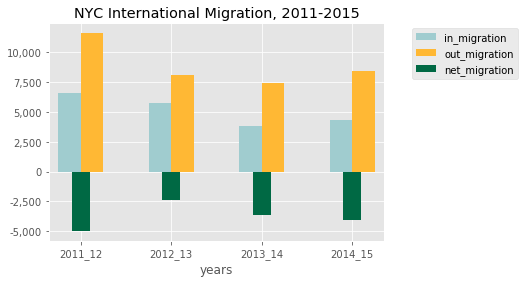

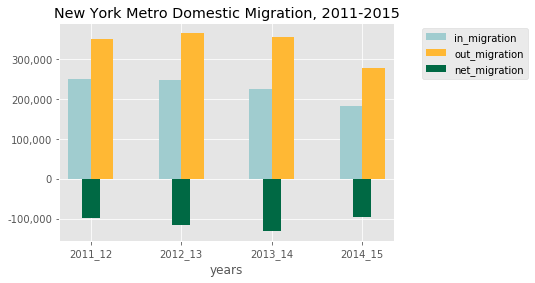

In [44]:
# plot each
plot_migration(total_city_dom, 'NYC Domestic Migration, 2011-2015')
plot_migration(total_city_foreign,'NYC International Migration, 2011-2015')

plot_migration(total_metro_dom, 'New York Metro Domestic Migration, 2011-2015')

# no need to show NYMA foreign migration ? - likely we won't show the foreign plots
# the domestic ones probably will include
# plot_migration(total_metro_foreign,'New York Metro International Migration, 2011-2015')

In [45]:
# for cummulative, just sum the rows (each row is a year of flows)
total_city_dom.sum()

in_migration     656,421
out_migration    952,613
net_migration   -296,192
dtype: float64

In [46]:
# put cummulative in one table if needed
# checked numbers for net migration for city only - foreign checks out
# domestic slightly off, but difference likely due to handling of 94 duplicates, so no problem
cum_mig=pd.concat([total_city_dom.sum(),total_city_foreign.sum(),total_metro_dom.sum(),total_metro_foreign.sum()], axis=1)
cum_mig.columns=['domestic_mig_nyc','foreign_mig_nyc','domestic_mig_nyma','foreign_mig_nyma']
cum_mig

,domestic_mig_nyc,foreign_mig_nyc,domestic_mig_nyma,foreign_mig_nyma
in_migration,"656,421","20,568","904,138","39,894"
out_migration,"952,613","35,587","1,347,562","68,297"
net_migration,"-296,192","-15,019","-443,424","-28,403"


# Year by year and cumulatively for domestic migration only, for NYC and NYM, who were the top senders/receivers?

In [47]:
# create table of flows grouped by metro area
grouped_by_metro=metro_flows.groupby(['cbsa_name','cbsa_code']).sum().reset_index()
grouped_by_metro.set_index('cbsa_name', inplace=True)

# get a list of net_flow columns--they needs to be recalculated after aggregation
net_cols=[c for c in grouped_by_metro.columns if 'net_flow' in c]
for col in net_cols:
    yr = col[-7:]
    grouped_by_metro[col]= grouped_by_metro['inflow' + yr] - grouped_by_metro['outflow' + yr]

In [48]:
# create ranks for inflow and outflow for each year for both city and by_metro flows to identify top places
domestic_city_flows.fillna (0, inplace=True)
grouped_by_metro.fillna(0, inplace=True)
for col in [c for c in domestic_city_flows.columns if 'inflow' in c or 'outflow' in c]:
    yr = col[-7:]
    in_out = col[0:2]
    domestic_city_flows['{}_rank{}'.format (in_out, yr)] = city_flows[col].rank (method='dense', ascending=False)
    grouped_by_metro['{}_rank{}'.format (in_out, yr)] = grouped_by_metro[col].rank (method='dense', ascending=False)

In [49]:
# add cummulative numbers for inflow, outflow, netflow for city and metro 
# these are totals for all 4 years
domestic_city_flows['tot_inflow']=domestic_city_flows[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)

domestic_city_flows['tot_outflow']=domestic_city_flows[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

domestic_city_flows['tot_net_flow']=domestic_city_flows['tot_inflow']-domestic_city_flows['tot_outflow']

In [50]:
grouped_by_metro['tot_inflow']=grouped_by_metro[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)

grouped_by_metro['tot_outflow']=grouped_by_metro[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

grouped_by_metro['tot_net_flow']=grouped_by_metro['tot_inflow']-grouped_by_metro['tot_outflow']

In [51]:
# add net change for each year
for i, year in enumerate(years):
    if i+1<len(years):
        yr_change='net_change'+years[i].split('_')[1]+'_'+years[i+1].split('_')[1]
        # this is the name of the column that holds net flow change between 2 periods
        print (yr_change)
        domestic_city_flows[yr_change]=domestic_city_flows['net_flow'+years[i+1]]-domestic_city_flows['net_flow'+years[i]]
        grouped_by_metro[yr_change]=grouped_by_metro['net_flow'+years[i+1]]-grouped_by_metro['net_flow'+years[i]]       

net_change12_13
net_change13_14
net_change14_15


In [52]:
# write the resulting data out to use for mapping in QGIS 
# these two dataframes have all the columns needed to make any other summaries and tables
# Janine will need net change for each year, and totals columns for all 4 years and net total
domestic_city_flows.to_csv('yrs_2011_2015_nyc_mig_by_county.csv')
grouped_by_metro.to_csv('yrs_2011_2015_ny_mig_by_metro.csv')

In [53]:
# number of top places
top = 10

In [54]:
# these functions select places that were ranked 1-top in any of the 4-year period
def get_top_senders(df):
    all_time_top_senders = \
        df[
            (df['in_rank2011_12'] <= top) | (df['in_rank2012_13'] <= top) | (
                df['in_rank2013_14'] <= top) | (
                df['in_rank2014_15'] <= top)].copy()

    return all_time_top_senders
    
def get_top_receivers(df):    
    all_time_top_receivers = \
        df[
            (df['ou_rank2011_12'] <= top) | (df['ou_rank2012_13'] <= top) | (
                df['ou_rank2013_14'] <= top) | (df['ou_rank2014_15'] <= top)].copy()

    return all_time_top_receivers

In [55]:
# get top places for city 
top_senders_to_nyc=get_top_senders(domestic_city_flows)
top_senders_to_nyc['county'] = top_senders_to_nyc['co_name'] + "," + top_senders_to_nyc['state']
top_senders_to_nyc = top_senders_to_nyc.set_index ('county').drop (['co_name', 'state'], 1)

top_receivers_from_nyc=get_top_receivers(domestic_city_flows)
top_receivers_from_nyc['county'] = top_receivers_from_nyc['co_name'] + "," + top_receivers_from_nyc['state']
top_receivers_from_nyc = top_receivers_from_nyc.set_index ('county').drop (['co_name', 'state'], 1)

In [56]:
# get top senders/receivers for metro area
top_senders_to_nyma=get_top_senders(grouped_by_metro)
top_receivers_from_nyma=get_top_receivers(grouped_by_metro)

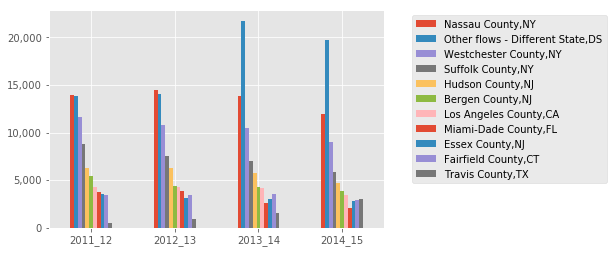

In [57]:
# not all top places in one year remain top in other years
# also distinguishing between 11 different colors is hard
# mabe table is better for showing many top places
# or in a chart, only show 5 top places
# We'll have to think about this some more - table may be the way to go, but even then I wonder if we 
# will need to present annual change. It would be easy to show aggregate change, the sum of all 4 years
# in either table or chart.
ax=top_senders_to_nyc[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].T.plot(kind='bar', rot=0)
ax.legend (bbox_to_anchor=(1.07, 1), loc='upper left')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set_xticklabels(years)
plt.show()

In [58]:
# Ex: show as table only year by year
# Checked all these numbers and verified the results
# As you pointed out can't show all in one table, as places switch ranks and some move out of top 10
top_receivers_from_nyc[['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15']].sort_values(['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15'], ascending=False)

,outflow2011_12,outflow2012_13,outflow2013_14,outflow2014_15
county,,,,
"Nassau County,NY","22,803","24,494","25,204","20,316"
"Westchester County,NY","16,967","18,414","17,173","13,986"
"Other flows - Different State,DS","16,808","17,381","25,405","23,807"
"Suffolk County,NY","9,785","9,636","9,271","8,171"
"Hudson County,NJ","8,761","9,141","8,818","7,273"
"Bergen County,NJ","7,687","7,977","7,124","5,816"
"Los Angeles County,CA","5,821","7,374","6,395","5,365"
"Fairfield County,CT","5,422","5,834","5,566","4,283"
"Essex County,NJ","5,180","5,536","5,819","4,791"


In [59]:
# Checked all these numbers and verified the results
# As you pointed out can't show all in one table, as places switch ranks and some move out of top 10
top_senders_to_nyc[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].sort_values(['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15'], ascending=False)

,inflow2011_12,inflow2012_13,inflow2013_14,inflow2014_15
county,,,,
"Nassau County,NY","13,995","14,458","13,877","11,900"
"Other flows - Different State,DS","13,850","14,062","21,728","19,743"
"Westchester County,NY","11,588","10,806","10,438","9,048"
"Suffolk County,NY","8,838","7,493","7,056","5,837"
"Hudson County,NJ","6,308","6,270","5,729","4,709"
"Bergen County,NJ","5,393","4,436","4,315","3,860"
"Los Angeles County,CA","4,297","4,265","4,231","3,465"
"Miami-Dade County,FL","3,755","3,862","2,571","2,062"
"Essex County,NJ","3,536","3,114","2,996","2,861"


In [60]:
top_receivers_from_nyma[['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15']].sort_values(['outflow2011_12','outflow2012_13','outflow2013_14','outflow2014_15'], ascending=False)

,outflow2011_12,outflow2012_13,outflow2013_14,outflow2014_15
cbsa_name,,,,
"Miami-Fort Lauderdale-West Palm Beach, FL","23,905","23,388","22,304","18,596"
"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","20,762","20,100","17,532","13,874"
"Bridgeport-Stamford-Norwalk, CT","11,486","12,518","12,205","9,683"
"Washington-Arlington-Alexandria, DC-VA-MD-WV","11,322","11,662","12,237","8,391"
"Los Angeles-Long Beach-Anaheim, CA","10,993","13,258","11,918","9,626"
"Atlanta-Sandy Springs-Roswell, GA","9,968","10,141","8,685","6,628"
"Boston-Cambridge-Newton, MA-NH","9,594","9,590","7,978","6,138"
"Orlando-Kissimmee-Sanford, FL","9,434","9,991","8,911","7,044"
"Allentown-Bethlehem-Easton, PA-NJ","8,676","8,032","7,727","6,069"


In [61]:
top_senders_to_nyma[['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15']].sort_values(['inflow2011_12','inflow2012_13','inflow2013_14','inflow2014_15'], ascending=False)

,inflow2011_12,inflow2012_13,inflow2013_14,inflow2014_15
cbsa_name,,,,
"Miami-Fort Lauderdale-West Palm Beach, FL","17,744","17,515","12,797","9,757"
"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","16,305","15,568","12,824","9,907"
"Washington-Arlington-Alexandria, DC-VA-MD-WV","9,053","9,350","7,689","7,660"
"Los Angeles-Long Beach-Anaheim, CA","8,482","8,595","7,946","6,196"
"Boston-Cambridge-Newton, MA-NH","8,305","8,495","6,940","5,001"
"Bridgeport-Stamford-Norwalk, CT","7,122","7,644","7,366","5,901"
"Atlanta-Sandy Springs-Roswell, GA","6,604","6,293","4,141","2,615"
"Allentown-Bethlehem-Easton, PA-NJ","6,393","5,629","4,065","3,288"
"Trenton, NJ","5,697","5,640","5,313","3,962"


## Deficit areas (negative net change) and Surpus Areas (positive net change)

In [62]:
## the top deficit and surplus areas dont stay same over the years--can't show yearly change in a single table/plot
## can show one year at a time; just change wihich column (net_flow_year) of the dataframe to show

In [63]:
# top surplus (send more to NYC than receive from NYC) counties for 2011-2012
# Checked 2011_12 and numbers correct, but something odd: here Pierce County WA is 10th place with 45
# In my data, 10th place is 019 Clinton County NY with 49. Clinton County is missing from here
domestic_city_flows[['co_name','state','net_flow2011_12']].sort_values('net_flow2011_12', ascending=False).head(n=20)

,co_name,state,net_flow2011_12
17,District of Columbia,DC,368
24,Suffolk County,MA,221
84,Collier County,FL,124
19,Middlesex County,MA,101
173,Utah County,UT,99
43,Orange County,CA,79
119,Dane County,WI,70
104,Tompkins County,NY,67
136,Onslow County,NC,56
264,Clinton County,NY,49


In [64]:
# top deficit (receive more from NYC than send to NYC) counties for 2011-2012
# Checked 2011_12 and numbers correct
domestic_city_flows[['co_name','state','net_flow2011_12']].sort_values('net_flow2011_12', ascending=True).head(n=20)

,co_name,state,net_flow2011_12
0,Nassau County,NY,"-8,808"
2,Westchester County,NY,"-5,379"
1,Other flows - Different State,DS,"-2,958"
4,Hudson County,NJ,"-2,453"
5,Bergen County,NJ,"-2,294"
9,Fairfield County,CT,"-2,010"
8,Essex County,NJ,"-1,644"
6,Los Angeles County,CA,"-1,524"
15,Broward County,FL,"-1,274"
25,Union County,NJ,"-1,215"


In [65]:
def plot_ranks(df, cols, title):

    """function to plot change in ranks over time
    :param df: dataframe to plot
    :param cols: a list of colum ranks to plot 
    :param title: Tile to display
    """
    df_ranks=df[cols]
    df_ranks.columns = [col[-7:] if 'rank' in col else col for col in df_ranks.columns]
    ax = df_ranks.T.plot (marker='o')
    ax.invert_yaxis ()
    ax.yaxis.set_major_locator (ticker.MaxNLocator (integer=True)) # display only whole numbers
    ax.legend (bbox_to_anchor=(1.07, 1), loc='upper left')
    ax.set_xlabel ('Year')
    ax.set_ylabel ('Rank')
    ax2 = ax.twinx () # get second y axis on the right
    ax2.yaxis.set_major_locator (ticker.MaxNLocator (integer=True))
    ax2.set_ylim (ax.get_ylim ())
    plt.title (title)
    plt.show ()

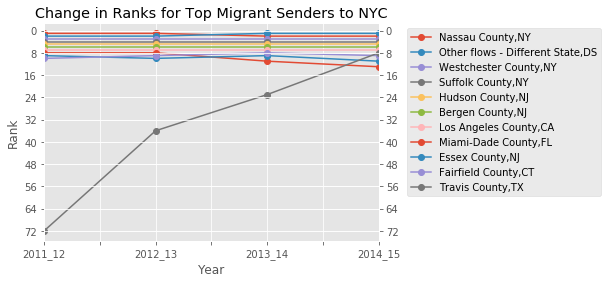

In [66]:
# plot change in ranks for top places that send migrants to nyc
plot_ranks (top_senders_to_nyc,['in_rank2011_12', 'in_rank2012_13', 'in_rank2013_14', 'in_rank2014_15'], 'Change in Ranks for Top Migrant Senders to NYC')

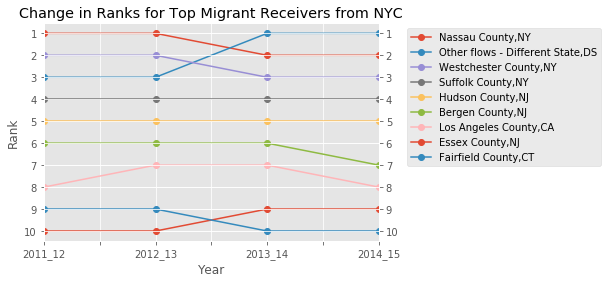

In [67]:
# plot change in ranks for top places that receive migrants from nyc
plot_ranks (top_receivers_from_nyc,['ou_rank2011_12', 'ou_rank2012_13', 'ou_rank2013_14', 'ou_rank2014_15'], 'Change in Ranks for Top Migrant Receivers from NYC')
# this is what I meant by showing ten records with default colors

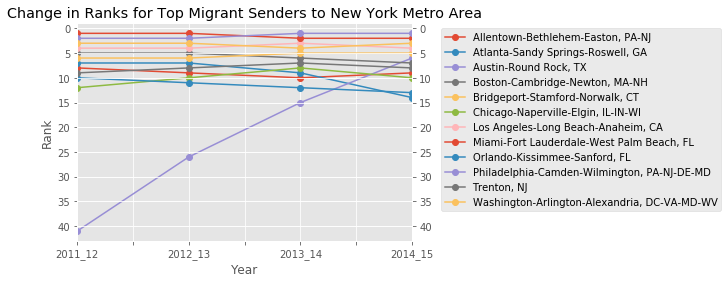

In [68]:
plot_ranks (top_senders_to_nyma,['in_rank2011_12', 'in_rank2012_13', 'in_rank2013_14', 'in_rank2014_15'], 'Change in Ranks for Top Migrant Senders to New York Metro Area')

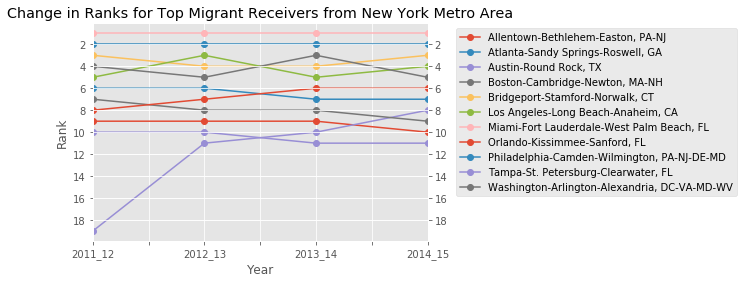

In [69]:
plot_ranks (top_receivers_from_nyma,['ou_rank2011_12', 'ou_rank2012_13', 'ou_rank2013_14', 'ou_rank2014_15'], 'Change in Ranks for Top Migrant Receivers from New York Metro Area')

In [70]:
# function to label counties in metro as 'suburban' and others as 'distant'
def is_suburban(col, metro):
    if col in metro:
        return 'suburban'
    else:
        return 'distant'

In [71]:
domestic_city_flows['cnty_status']=domestic_city_flows.co_fips.apply(lambda x: is_suburban(x, nyma))

In [72]:
by_status=domestic_city_flows[['cnty_status','inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15',
                              'outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].groupby('cnty_status').sum()

In [73]:
by_status['pct_dif_inflow']=(by_status['inflow2014_15']-by_status['inflow2011_12'])/by_status['inflow2011_12']*100
by_status['pct_dif_outflow']=(by_status['outflow2014_15']-by_status['outflow2011_12'])/by_status['outflow2011_12']*100
by_status['tot_inflow']=by_status[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].sum(axis=1)
by_status['tot_outflow']=by_status[['outflow2011_12','outflow2012_13',
                               'outflow2013_14','outflow2014_15']].sum(axis=1)

In [74]:
by_status

,inflow2011_12,inflow2012_13,inflow2013_14,inflow2014_15,outflow2011_12,outflow2012_13,outflow2013_14,outflow2014_15,pct_dif_inflow,pct_dif_outflow,tot_inflow,tot_outflow
cnty_status,,,,,,,,,,,,
distant,"114,733","112,531","103,212","89,572","150,765","156,652","149,882","122,391",-22,-19,"420,048","579,690"
suburban,"65,726","61,282","58,540","50,825","95,121","100,404","97,525","79,873",-23,-16,"236,373","372,923"


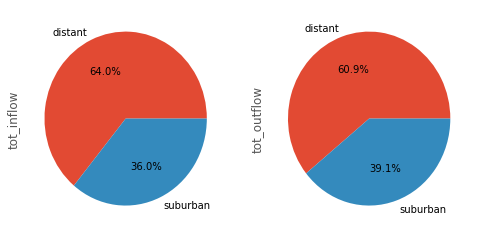

In [75]:
# inflows and outflows to NYC from suburban counties accounted for more than third of all domestic NYC flows 
ax=by_status[['tot_inflow','tot_outflow']].plot.pie(subplots=True, legend=False, autopct='%1.1f%%',figsize=(8,4))

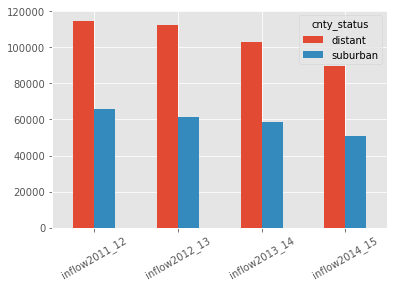

In [76]:
# yearly change in inflows to NYC for suburban and distant counties
by_status[['inflow2011_12','inflow2012_13',
                               'inflow2013_14','inflow2014_15']].T.plot(kind='bar', rot=30)